## SyriaTel Customer Churn

### Project Overview
The objective of this project is to develop a classification model that predicts whether a customer will churn (leave the service) based on various customer attributes. This is a binary classification problem where the target variable is whether the customer churned or not.


### Business Problem
Churn prediction is crucial for businesses as retaining customers is often more cost-effective than acquiring new ones. By accurately predicting customer churn, the business can take proactive measures to retain customers, thereby reducing churn rates and improving profitability.

### 2. Data Collection
#### Dataset Selection

We are using a telecom customer dataset for this project. The dataset contains information such as the customer's state, account length, area code, and various usage metrics like the number of customer service calls, total day minutes, etc.


Number of features: 21 (after excluding 'phone number' and the target variable)

#### Data Import and Initial Inspection

Let's load the dataset and take a look at the first few rows to understand its structure.

In [2]:
import os
import pandas as pd

# Define the path to the CSV file
file_path = os.path.join('Data', 'bigml_59c28831336c6604c800002a.csv')

# Load the CSV file
data = pd.read_csv(file_path)

# Display the first few rows of the data to inspect it
data.head()


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### 3. Data Exploration and Preprocessing
#### Exploratory Data Analysis (EDA)
Before preprocessing, let's explore the target variable to understand the distribution of churned vs. non-churned customers.

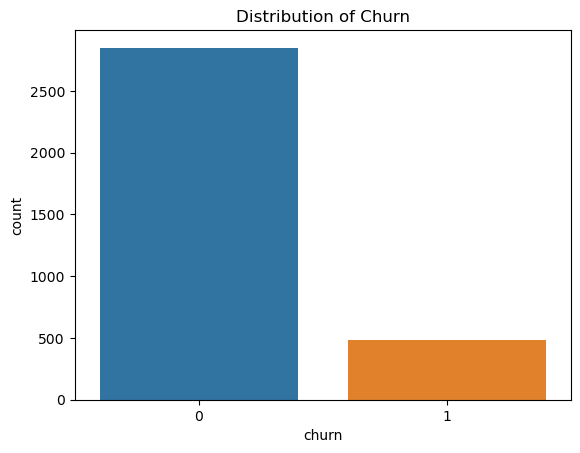

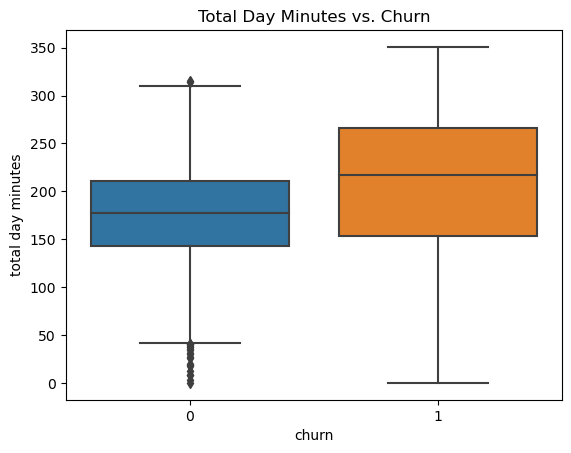

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the target variable
sns.countplot(x='churn', data=data)
plt.title('Distribution of Churn')
plt.show()

# Visualize relationships between key features and the target variable
sns.boxplot(x='churn', y='total day minutes', data=data)
plt.title('Total Day Minutes vs. Churn')
plt.show()


### Data Cleaning and Preparation
Now, we'll prepare the data for modeling. This involves handling missing values, encoding categorical variables, and scaling numerical features.

In [5]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable 'churn'
label_encoder = LabelEncoder()
data['churn'] = label_encoder.fit_transform(data['churn'])

# Define feature columns and target column
X = data.drop(columns=['phone number', 'churn'])  # Dropping 'phone number' as it is likely not useful
y = data['churn']

# Handle categorical variables: 'state', 'international plan', 'voice mail plan'
categorical_features = ['state', 'international plan', 'voice mail plan']
numerical_features = X.columns.difference(categorical_features)


### 4. Baseline Model Development

#### Model Selection: 
We start with Logistic Regression, a simple and interpretable model that is a good starting point for binary classification problems. This model helps in understanding feature importance and is often effective in cases where the relationship between the features and the target is linear or approximately linear.

#### Model Training: 
We split the data into training and testing sets, train the logistic regression model, and evaluate its performance.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline and model training
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
baseline_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['account length', 'area code', 'customer service calls',
       'number vmail messages', 'total day calls', 'total day charge',
       'total day minutes', 'total eve calls', 'total eve charge',
       'total eve minutes', 'total intl calls', 'total intl charge',
       'total intl minutes', 'total night calls', 'total night charge',
       'total night minutes'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['state',
                                                   'international plan',
                                                   'voice mail plan'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

### Model Evaluation
Evaluate the baseline model's performance using classification metrics such as accuracy, precision, recall, and F1-score.

In [14]:
y_pred_baseline = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_report = classification_report(y_test, y_pred_baseline, target_names=['No Churn', 'Churn'])

print(f"Baseline Model Accuracy: {baseline_accuracy}")
print(f"Baseline Model Classification Report:\n{baseline_report}")


Baseline Model Accuracy: 0.8605697151424287
Baseline Model Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.96      0.92       570
       Churn       0.54      0.26      0.35        97

    accuracy                           0.86       667
   macro avg       0.71      0.61      0.64       667
weighted avg       0.83      0.86      0.84       667



### 5. Nonparametric Model Exploration
#### Decision Tree Model: 
Next, we explore a Decision Tree model, which is a nonparametric model. Decision Trees do not assume any specific structure for the underlying data, making them flexible and capable of capturing non-linear relationships. Decision Trees can also handle categorical features natively without needing encoding.

#### Model Training: 
We will train a Decision Tree model on the same dataset and evaluate its performance.

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Pipeline and model training with Decision Tree
tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
tree_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['account length', 'area code', 'customer service calls',
       'number vmail messages', 'total day calls', 'total day charge',
       'total day minutes', 'total eve calls', 'total eve charge',
       'total eve minutes', 'total intl calls', 'total intl charge',
       'total intl minutes', 'total night calls', 'total night charge',
       'total night minutes'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['state',
                                                   'international plan',
                                                   'voice mail plan'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

#### Model Evaluation: 
Evaluate the Decision Tree model using the same metrics.



In [11]:
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
tree_report = classification_report(y_test, y_pred_tree, target_names=['No Churn', 'Churn'])

print(f"Decision Tree Model Accuracy: {tree_accuracy}")
print(f"Decision Tree Model Classification Report:\n{tree_report}")


Decision Tree Model Accuracy: 0.908
Decision Tree Model Classification Report:
              precision    recall  f1-score   support

    No Churn       0.95      0.94      0.95       855
       Churn       0.68      0.70      0.69       145

    accuracy                           0.91      1000
   macro avg       0.81      0.82      0.82      1000
weighted avg       0.91      0.91      0.91      1000



### Comparison Between Logistic Regression and Decision Tree:

#### Interpretability: 
Logistic Regression is more interpretable as it provides clear coefficients for each feature, showing their direct impact on the target variable. Decision Trees, on the other hand, are less interpretable, especially as the depth of the tree increases.

#### Handling Non-Linearity: 
Decision Trees can capture non-linear relationships between features, which Logistic Regression may miss unless feature engineering or interaction terms are added.

#### Overfitting: 
Decision Trees are prone to overfitting, especially with deep trees, while Logistic Regression is less likely to overfit due to its linear nature. Regularization techniques can be applied to Logistic Regression to further control overfitting.

 Depending on the results, if the Decision Tree significantly outperforms Logistic Regression without overfitting (which can be assessed using techniques like cross-validation), it might be a better choice. However, if the tree is overfitting or not performing better, Logistic Regression might be preferable due to its simplicity and generalization ability.

### 6. Nonparametric Model Exploration: Random Forest

#### Random Forest Model: 
A Random Forest is an ensemble method that builds multiple Decision Trees and combines their outputs to create a more robust and accurate prediction. This method tends to outperform single Decision Trees by reducing overfitting while capturing non-linear patterns.

#### Model Training:
We will first train a Random Forest using the entire set of features and then analyze the feature importance. Based on this analysis, we can retrain the model using only the most important features to see if accuracy improves.

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline and model training with Random Forest
forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

forest_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['account length', 'area code', 'customer service calls',
       'number vmail messages', 'total day calls', 'total day charge',
       'total day minutes', 'total eve calls', 'total eve charge',
       'total eve minutes', 'total intl calls', 'total intl charge',
       'total intl minutes', 'total night calls', 'total night charge',
       'total night minutes'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['state',
                                                   'international plan',
                                                   'voice mail plan'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

#### Model Evaluation:
After training, we evaluate the Random Forest using the same metrics to compare its performance with Logistic Regression and Decision Tree models.

In [16]:
y_pred_forest = forest_model.predict(X_test)
forest_accuracy = accuracy_score(y_test, y_pred_forest)
forest_report = classification_report(y_test, y_pred_forest, target_names=['No Churn', 'Churn'])

print(f"Random Forest Model Accuracy: {forest_accuracy}")
print(f"Random Forest Model Classification Report:\n{forest_report}")


Random Forest Model Accuracy: 0.9370314842578711
Random Forest Model Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.99      0.96       570
       Churn       0.91      0.63      0.74        97

    accuracy                           0.94       667
   macro avg       0.93      0.81      0.85       667
weighted avg       0.94      0.94      0.93       667



#### Analyzing Feature Importance:
We now extract the feature importance scores from the Random Forest model and visualize the top features. This helps in understanding which features had the most impact on the model’s decision-making process.

Top 10 most important features:
                   Feature  Importance
5         total day charge    0.138037
6        total day minutes    0.128742
2   customer service calls    0.107534
8         total eve charge    0.055784
9        total eve minutes    0.053391
10        total intl calls    0.045024
11       total intl charge    0.043839
12      total intl minutes    0.039535
67   international plan_no    0.035531
68  international plan_yes    0.035491


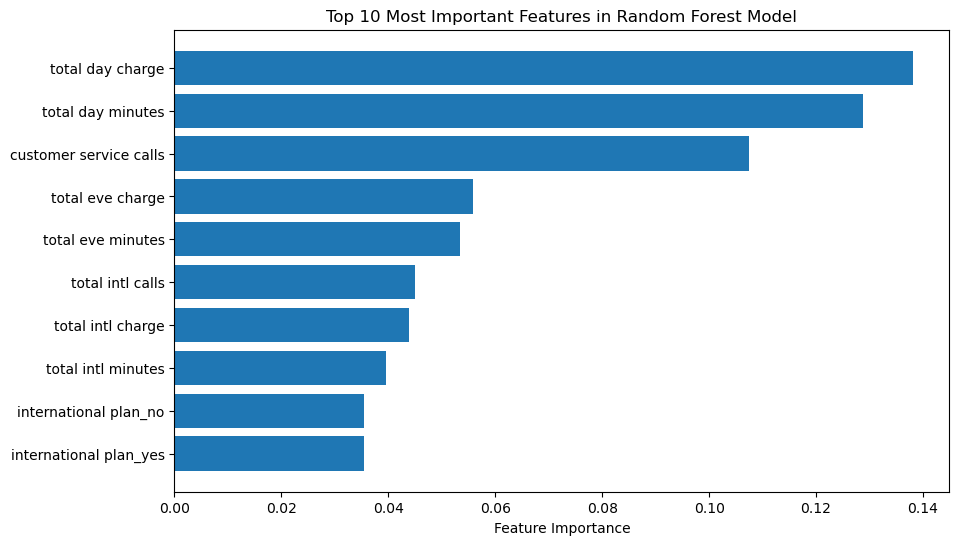

In [17]:

import matplotlib.pyplot as plt

# Get feature importances from the Random Forest model
feature_importances = forest_model.named_steps['classifier'].feature_importances_

# Get the feature names from the preprocessor
categorical_feature_names = forest_model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(categorical_feature_names)

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 most important features:")
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10))
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features in Random Forest Model')
plt.show()


#### Feature Subset Selection:
Based on the importance scores, we can select the top features that contributed the most to the model's performance. We'll retrain the Random Forest model using only these features and check if the accuracy improves.

Extract the Correct Transformed Feature Names:

In [21]:
# Get the feature names from the preprocessor (numerical and one-hot-encoded categorical features)
categorical_feature_names = forest_model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(categorical_feature_names)

# Extract the top 10 most important features from the preprocessed dataset
top_features = feature_importance_df['Feature'].head(10).values

# Ensure that top_features is correctly aligned with the preprocessed dataset columns
X_train_top = pd.DataFrame(X_train, columns=all_feature_names)[top_features]
X_test_top = pd.DataFrame(X_test, columns=all_feature_names)[top_features]


We now apply the imputation only to the relevant columns, and ensure that the categorical features are handled correctly:

In [23]:
# Display all available feature names in the transformed dataset to check for any mismatch
print("Available features after one-hot encoding and scaling:\n", all_feature_names)


Available features after one-hot encoding and scaling:
 ['account length', 'area code', 'customer service calls', 'number vmail messages', 'total day calls', 'total day charge', 'total day minutes', 'total eve calls', 'total eve charge', 'total eve minutes', 'total intl calls', 'total intl charge', 'total intl minutes', 'total night calls', 'total night charge', 'total night minutes', 'state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY', 

In [26]:
# Ensure that top features exist in the transformed dataset's columns
top_features = feature_importance_df['Feature'].head(10).values

# Check if top_features exist in all_feature_names (the transformed dataset columns)
valid_top_features = [feature for feature in top_features if feature in all_feature_names]

# If the selected top features are correct, proceed with this subset of features
print("Valid Top Features:", valid_top_features)


Valid Top Features: ['total day charge', 'total day minutes', 'customer service calls', 'total eve charge', 'total eve minutes', 'total intl calls', 'total intl charge', 'total intl minutes', 'international plan_no', 'international plan_yes']


Subset the Data Using Valid Top Features:

In [27]:
# Subset the training and test datasets to include only the valid top features
X_train_top = pd.DataFrame(X_train, columns=all_feature_names)[valid_top_features]
X_test_top = pd.DataFrame(X_test, columns=all_feature_names)[valid_top_features]


Separate Numerical and Categorical Features:

Since there are both numerical features (e.g., total day charge, total intl calls) and categorical features (international plan_no, international plan_yes), we'll handle them accordingly:

In [28]:
# Separate numerical and categorical features
top_numerical_features = ['total day charge', 'total day minutes', 'customer service calls', 
                          'total eve charge', 'total eve minutes', 'total intl calls', 
                          'total intl charge', 'total intl minutes']

top_categorical_features = ['international plan_no', 'international plan_yes']


Impute Missing Values for Numerical Features 


In [36]:
from sklearn.impute import SimpleImputer

# Impute missing values for numerical features only
top_numerical_features = ['total day charge', 'total day minutes', 'customer service calls', 
                          'total eve charge', 'total eve minutes', 'total intl calls', 
                          'total intl charge', 'total intl minutes']

# Check for missing values in numerical columns
missing_in_numerical = X_train_top[top_numerical_features].isnull().sum()

if missing_in_numerical.sum() > 0:
    print(f"Missing values found in numerical columns: {missing_in_numerical}. Performing imputation.")
    
    # Impute numerical features
    numerical_imputer = SimpleImputer(strategy='mean')
    X_train_top[top_numerical_features] = numerical_imputer.fit_transform(X_train_top[top_numerical_features])
    X_test_top[top_numerical_features] = numerical_imputer.transform(X_test_top[top_numerical_features])
else:
    print("No missing values found in numerical columns. Skipping imputation.")


No missing values found in numerical columns. Skipping imputation.


Check for Missing Values in the Entire Dataset

In [37]:
# Check for any remaining missing values in the entire dataset
print("Missing values in X_train_top:")
print(X_train_top.isnull().sum())

print("Missing values in X_test_top:")
print(X_test_top.isnull().sum())


Missing values in X_train_top:
total day charge             0
total day minutes            0
customer service calls       0
total eve charge             0
total eve minutes            0
total intl calls             0
total intl charge            0
total intl minutes           0
international plan_no     2666
international plan_yes    2666
dtype: int64
Missing values in X_test_top:
total day charge            0
total day minutes           0
customer service calls      0
total eve charge            0
total eve minutes           0
total intl calls            0
total intl charge           0
total intl minutes          0
international plan_no     667
international plan_yes    667
dtype: int64


Fill the NaNs in One-Hot Encoded Columns: Since international plan_no and international plan_yes are mutually exclusive (one will always be NaN when the other is 1), we can fill the missing values with 0, indicating that the particular plan is not applicable for that customer.

In [38]:
# Fill missing values in the one-hot encoded 'international plan' columns with 0
X_train_top[['international plan_no', 'international plan_yes']] = X_train_top[['international plan_no', 'international plan_yes']].fillna(0)
X_test_top[['international plan_no', 'international plan_yes']] = X_test_top[['international plan_no', 'international plan_yes']].fillna(0)

# Verify the missing values are handled
print("Missing values in X_train_top after filling NaNs:")
print(X_train_top.isnull().sum())

print("Missing values in X_test_top after filling NaNs:")
print(X_test_top.isnull().sum())


Missing values in X_train_top after filling NaNs:
total day charge          0
total day minutes         0
customer service calls    0
total eve charge          0
total eve minutes         0
total intl calls          0
total intl charge         0
total intl minutes        0
international plan_no     0
international plan_yes    0
dtype: int64
Missing values in X_test_top after filling NaNs:
total day charge          0
total day minutes         0
customer service calls    0
total eve charge          0
total eve minutes         0
total intl calls          0
total intl charge         0
total intl minutes        0
international plan_no     0
international plan_yes    0
dtype: int64


Train the new Random Forest Model:


In [39]:
# Train the Random Forest model using the valid top features
forest_model_top = RandomForestClassifier(random_state=42)
forest_model_top.fit(X_train_top, y_train)

# Predict on the test set
y_pred_forest_top = forest_model_top.predict(X_test_top)

# Evaluate the model's performance
forest_accuracy_top = accuracy_score(y_test, y_pred_forest_top)
forest_report_top = classification_report(y_test, y_pred_forest_top, target_names=['No Churn', 'Churn'])

# Output the results
print(f"Random Forest Model (Top Features) Accuracy: {forest_accuracy_top}")
print(f"Random Forest Model (Top Features) Classification Report:\n{forest_report_top}")


Random Forest Model (Top Features) Accuracy: 0.896551724137931
Random Forest Model (Top Features) Classification Report:
              precision    recall  f1-score   support

    No Churn       0.92      0.96      0.94       570
       Churn       0.70      0.51      0.59        97

    accuracy                           0.90       667
   macro avg       0.81      0.73      0.76       667
weighted avg       0.89      0.90      0.89       667

